In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Load and clean the training data**

We load the training data.

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


For each feature, we clean the data so the values make more sense

We then clean the data by : 
- selecting the best 43 features with human decision and correlation analysis
- removing the nan values by the median of the rest of the feature for continuous values
- removing the nan values by the -1 for categorical features
- removing the features where the variance is zero since they are constants for all samples

In [5]:
feat_con = [13, 15, 16, 17, 24 ,25 ,26 ,27 ,28 ,29 ,33 ,37,49 ,59 ,60 ,62 ,63 ,75 ,77 ,78 ,
             79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,89 ,90 ,92 ,93 ,94, 98 ,110 ,111 ,112 ,113 ,114 ,143
            ,147 ,148 ,149 ,150 ,168 ,195 ,197 , 206 ,207 ,208 ,209 ,210 ,211 ,212 ,213 ,219, 220, 221
            ,222, 226, 228, 229, 248 ,250 ,251 ,252 ,253 ,262 ,264 ,266,267,268,269,270,271,276,277,285,
             286,287,288,291,292, 293,294, 295, 296, 297, 299, 300, 301, 302, 303, 304]

# Generate a list of all indices from 1 to 320
all_indices = list(range(0, 321))

# Use a list comprehension to filter out indices not in your array
feat_cat = [idx for idx in all_indices if idx not in feat_con]

In [9]:
xt_feat = x_train
xt_feat = preprocessing(xt_feat)
xt_feat = gen_clean(xt_feat, feat_cat, feat_con)
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 321 features !


In [10]:
pca_indices, idx = pca(xt_feat)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 161 first most influent features given by pca_indices


In [11]:
x_train_pca = xt_feat[:, pca_indices]
x_train_pca = x_train_pca[:, :idx]

print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 161 features


# Least-squares

We find the least-squares solutions using the normal equations.

First, we separate our data in a training set(70%) and testing set(30%).

In [15]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.8)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (262508, 161) ; tx_te shape : (65627, 161)
       y_tr : (262508,)     ;        y_te : (65627,)


Now we build our models for least-squares

In [17]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 162 features !


### **We find the solutions**

In [18]:
start_time = datetime.datetime.now()
w, loss = least_squares(y, tx)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds with loss : {loss}")

LinAlgError: Singular matrix

### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [10]:
pred_data = np.dot(tx, w)

pred_data[pred_data > 0] = 1
pred_data[pred_data < 0] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 91.20090206971014%
Precision: 44.11764705882353%
Recall : 0.07423170188548522%
F1-score : 0.14821402104639098%


Now we compute some metrics for our test data (40% of the total data)

In [11]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > 0] = 1
pred_test[pred_test < 0] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 91.09517375890127%
Precision: 56.25%
Recall : 0.10264598540145986%
F1-score : 0.20491803278688525%


### Feature analysis

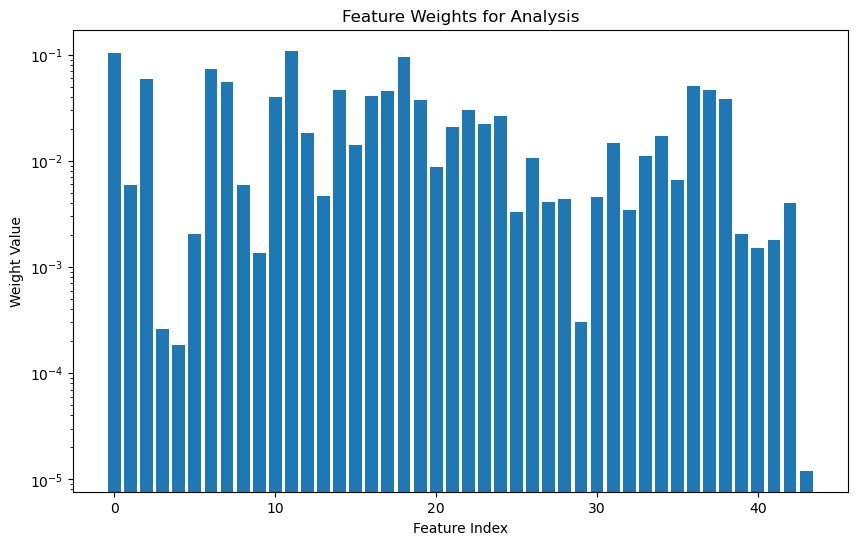

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# **Prediction on test data**

In [13]:
start_time = datetime.datetime.now()

tx_test = gen_clean(x_test, feat_cat, feat_con)
tx_test = tx_test[:, feat]
tx_te = np.c_[np.ones(tx_test.shape[0]), tx_test]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

Execution time 0.396857 seconds
The data has 109379 samples and 43 features !


In [14]:
pred_te = np.dot(tx_te, w)

pred_te[pred_te > 0] = 1
pred_te[pred_te < 0] = -1

indices_one = np.where(pred_te == 1)

In [15]:
create_csv_submission(test_ids, pred_te, "../data/least-squares.csv")